In [1]:
from platform import python_version 

print(python_version()) # Require Py 3.6 for tensorflow 2 

3.6.12


In [2]:
# import libraries:

import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
import numpy as np

In [3]:
# Read in the pickle files from last notebook


# Train Sets ------
train = pd.read_pickle('train.pkl')
train_one_hot = pd.read_pickle('train_one_hot.pkl') 
train_one_hot_nofare = pd.read_pickle('train_one_hot_nofare.pkl')
train_UpLow = pd.read_pickle('train_UpLow.pkl')

# Test Sets: ------
test = pd.read_pickle('test.pkl')
test_one_hot_nofare = pd.read_pickle('test_one_hot_nofare.pkl')

In [4]:
# drop the fare vairable from dataframe
train_UpLow_fare = train_UpLow 
train_UpLow_nofare = train_UpLow.drop('Fare', axis=1)

In [5]:
# create 3 datasets to check accuracy. These all have ages as levels (not one hot encoded).

train_fare_stand = train
train_fare_stand['Fare'] = (train_fare_stand['Fare']-train_fare_stand['Fare'].mean())/train_fare_stand['Fare'].std() # Standardising
train_nofare = train.drop('Fare', axis=1)


## Lets look at fitting our first models:

In [6]:
# Set up a Response Vector = Y and Data Vector = X using the dataset we want to explore

dataset = train_one_hot_nofare #this dataset can chage depending on what we're testing

X_train = dataset.drop('Survived', axis = 1)
Y_train = dataset['Survived']

X_test = test.drop('Survived' , axis = 1)
Y_test = test['Survived']


# Set up vectors of feature names for plotting importance later:

X_names = list(X_train.columns)
Y_names = Y_train.name

# for each method we want to tune any hyperparameters using k-fold cross validation:
from sklearn.model_selection import cross_val_score

In [7]:
X_names # Sanity Check

['Pclass',
 'Sex',
 'Embarked',
 'Title',
 'Deck',
 'GroupSize',
 'Adolescent',
 'Adult',
 'Child',
 'Senior',
 'Young Adult']

In [8]:
Y_names

'Survived'

## K-Nearest-Neighbours

In [9]:
## KNearestNeighbours

from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_train, Y_train)

KNeighborsClassifier()

In [10]:
# Cross Val:

CV_neigh = cross_val_score(neigh, X_train, Y_train, cv = 10, scoring='accuracy')
print('Accuracy for 10 folds', CV_neigh)
mean_neigh = CV_neigh.mean()
print('Mean Accuracy:', mean_neigh)
std_neigh = CV_neigh.std()
print('Standard Deviation of Accuracy', std_neigh)


Accuracy for 10 folds [0.81111111 0.83146067 0.7752809  0.86516854 0.87640449 0.80898876
 0.83146067 0.7752809  0.8988764  0.87640449]
Mean Accuracy: 0.835043695380774
Standard Deviation of Accuracy 0.041017118590292244


In [11]:
# How to select an optimal number of neighbours:

neighbour_num = [2,3,4,5,6,7,8,9,10]
d = []

for i in neighbour_num :
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(X_train, Y_train)
    CV_neigh = cross_val_score(neigh, X_train, Y_train, cv = 10, scoring='accuracy')
    d.append((i, CV_neigh.mean(), CV_neigh.std()))
    
    tuning_table = pd.DataFrame(d, columns =('K', 'Mean_Accuracy', 'Std_Accuracy'))
    
print('Tuning Table for K:\n' , tuning_table)

Tuning Table for K:
     K  Mean_Accuracy  Std_Accuracy
0   2       0.790150      0.045095
1   3       0.826055      0.041734
2   4       0.820462      0.034590
3   5       0.835044      0.041017
4   6       0.841785      0.040797
5   7       0.824981      0.040501
6   8       0.835069      0.039935
7   9       0.833895      0.035453
8  10       0.830524      0.036401


In [12]:
print( 'Max Accuracy:', tuning_table.Mean_Accuracy.max() , 
          '  When K =', tuning_table['K'].loc[tuning_table['Mean_Accuracy'] == tuning_table.Mean_Accuracy.max()].values[0] )
print( 'Min Std : ' , tuning_table.Std_Accuracy.min() ,
         '  When K =', tuning_table['K'].loc[tuning_table['Std_Accuracy'] == tuning_table.Std_Accuracy.min()].values[0]  )

Max Accuracy: 0.8417852684144819   When K = 6
Min Std :  0.034590220126847114   When K = 4


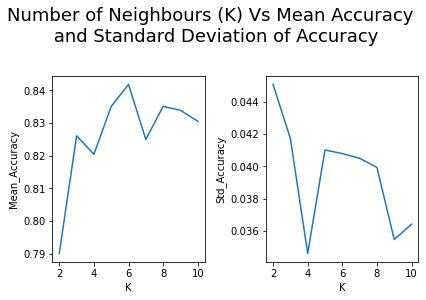

In [13]:
## Plot a line graph
#tt = tuning_table.reset_index().melt('index', var_name='cols',  value_name='vals')
#g = sns.catplot(x="index", y="vals", hue='cols', data=tt, kind='point')
fig, ax =plt.subplots(1,2)

sns.lineplot(x=tuning_table['K'], y="Mean_Accuracy", data=tuning_table, ax=ax[0])
sns.lineplot(x=tuning_table['K'], y="Std_Accuracy", data=tuning_table, ax=ax[1])
#g.set_xticklabels(['1','2','3','4','5','6','7','8'])
#h.set_xticklabels(['1','2','3','4','5','6','7','8'])
fig.suptitle('Number of Neighbours (K) Vs Mean Accuracy \n and Standard Deviation of Accuracy', fontsize=18, y=1.03)
fig.tight_layout()
plt.show()

In [14]:
# Thus we can choose K=6 as a mean variance trade off. Giving:

neigh = KNeighborsClassifier(n_neighbors=6)
neigh.fit(X_train, Y_train)
CV_neigh = cross_val_score(neigh, X_train, Y_train, cv = 10, scoring='accuracy')
print('Accuracy for 10 folds', CV_neigh)
mean_neigh = CV_neigh.mean()
print('Mean Accuracy:', mean_neigh)
std_neigh = CV_neigh.std()
print('Standard Deviation of Accuracy', std_neigh)


Accuracy for 10 folds [0.81111111 0.84269663 0.7752809  0.87640449 0.87640449 0.82022472
 0.84269663 0.78651685 0.8988764  0.88764045]
Mean Accuracy: 0.8417852684144819
Standard Deviation of Accuracy 0.040796970764718166


In [15]:
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = neigh.predict(X_train)

cf_matrix = confusion_matrix(Y_train, Y_pred)

print(confusion_matrix(Y_train, Y_pred))
print(classification_report(Y_train, Y_pred))

# Saving other metric (Recall, Precision, F1-Score)

report = classification_report(Y_train, Y_pred, output_dict=True)
recall_knn = report['0']['recall']
precision_knn = report['0']['precision']
f1_knn = report['0']['f1-score']


[[507  42]
 [ 85 257]]
              precision    recall  f1-score   support

           0       0.86      0.92      0.89       549
           1       0.86      0.75      0.80       342

    accuracy                           0.86       891
   macro avg       0.86      0.84      0.85       891
weighted avg       0.86      0.86      0.86       891



In [16]:
CR = classification_report(Y_train, Y_pred, output_dict=True)


Text(0.5, 0.98, 'Confustion Matrix')

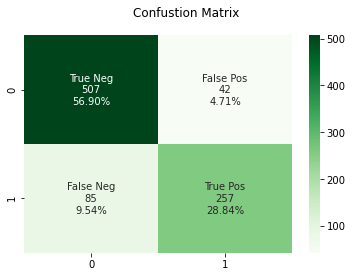

In [17]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Greens')
plt.suptitle('Confustion Matrix')

## Logistic Regression

In [18]:
## Logistic Regression:

from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=1000)

logreg.fit(X_train, Y_train)
CV_logreg = cross_val_score(logreg, X_train, Y_train, cv = 10, scoring='accuracy')
print('Accuracy for 10 folds', CV_logreg)
mean_logreg = CV_logreg.mean()
print('Mean Accuracy:', mean_logreg)
std_logreg = CV_logreg.std()
print('Standard Deviation of Accuracy', std_logreg)

# We dont have hyperparameters to tune but we could use best subset selction and regularisation methods


Accuracy for 10 folds [0.83333333 0.78651685 0.74157303 0.80898876 0.83146067 0.76404494
 0.79775281 0.79775281 0.83146067 0.76404494]
Mean Accuracy: 0.795692883895131
Standard Deviation of Accuracy 0.03029369904495602


In [19]:
from sklearn.model_selection import GridSearchCV

# Might need a special grid for logisitic regression. Or even tailored to each classifier.
grid={"C":np.logspace(-3,3,7)}
logreg_l1 = LogisticRegression(penalty = 'l1', solver='liblinear',max_iter=1000) #LASSO
logreg_l2 = LogisticRegression(penalty = 'l2',max_iter=1000) #Ridge
# logreg_elas = LogisticRegression(penalty = 'elasticnet' , solver = 'saga') leave this for now if adding need put in vector below
regs = [logreg_l1, logreg_l2]


for logreg in regs:
    CV_logreg=GridSearchCV(logreg , grid , cv=10)
    CV_logreg.fit(X_train, Y_train)
    print("Penalty:" , logreg.penalty )
    print("Tuned Hyperparameters : (Best Parameters) ",CV_logreg.best_params_)
    print("Accuracy :",CV_logreg.best_score_)
    print('-------------------------------------')
    means = CV_logreg.cv_results_['mean_test_score']
    stds = CV_logreg.cv_results_['std_test_score']
    
    for mean, std, params in zip(means, stds, CV_logreg.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print('-------------------------------------')
    print('-------------------------------------')



Penalty: l1
Tuned Hyperparameters : (Best Parameters)  {'C': 1.0}
Accuracy : 0.7979400749063671
-------------------------------------
0.616 (+/-0.007) for {'C': 0.001}
0.741 (+/-0.094) for {'C': 0.01}
0.784 (+/-0.069) for {'C': 0.1}
0.798 (+/-0.056) for {'C': 1.0}
0.787 (+/-0.048) for {'C': 10.0}
0.788 (+/-0.052) for {'C': 100.0}
0.788 (+/-0.052) for {'C': 1000.0}
-------------------------------------
-------------------------------------
Penalty: l2
Tuned Hyperparameters : (Best Parameters)  {'C': 1.0}
Accuracy : 0.795692883895131
-------------------------------------
0.707 (+/-0.053) for {'C': 0.001}
0.781 (+/-0.076) for {'C': 0.01}
0.781 (+/-0.063) for {'C': 0.1}
0.796 (+/-0.061) for {'C': 1.0}
0.787 (+/-0.052) for {'C': 10.0}
0.788 (+/-0.052) for {'C': 100.0}
0.788 (+/-0.052) for {'C': 1000.0}
-------------------------------------
-------------------------------------


In [20]:
logreg.get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

In [21]:
CV_logreg.get_params().keys()

dict_keys(['cv', 'error_score', 'estimator__C', 'estimator__class_weight', 'estimator__dual', 'estimator__fit_intercept', 'estimator__intercept_scaling', 'estimator__l1_ratio', 'estimator__max_iter', 'estimator__multi_class', 'estimator__n_jobs', 'estimator__penalty', 'estimator__random_state', 'estimator__solver', 'estimator__tol', 'estimator__verbose', 'estimator__warm_start', 'estimator', 'iid', 'n_jobs', 'param_grid', 'pre_dispatch', 'refit', 'return_train_score', 'scoring', 'verbose'])

In [22]:
# Fit best models in each case. 

LR_L1 = LogisticRegression(C=100, penalty='l1', solver = 'liblinear',max_iter=1000).fit(X_train, Y_train)
LR_L2 = LogisticRegression(C=100, penalty='l2',max_iter=1000).fit(X_train, Y_train)

# Extract scores:
CV_LR_L1 = cross_val_score( LR_L1 , X_train, Y_train, cv = 10, scoring='accuracy')
mean_lasso = CV_LR_L1.mean()
std_lasso = CV_LR_L1.std()

CV_LR_L2 = cross_val_score( LR_L2, X_train, Y_train, cv = 10, scoring='accuracy')
mean_ridge = CV_LR_L2.mean()
std_ridge = CV_LR_L2.std()


In [23]:
from sklearn.metrics import accuracy_score

#print('logistic_regression (L1) accuracy:',accuracy_score(Y_test, LR_L1.predict(X_test)))
#print('logistic_regression (L2) accuracy:',accuracy_score(Y_test, LR_L2.predict(X_test)))

In [24]:
from sklearn.metrics import classification_report, confusion_matrix

# LASSO:
    
Y_pred_L1 = LR_L1.predict(X_train)

# Saving other metric (Recall, Precision, F1-Score)

report = classification_report(Y_train, Y_pred_L1, output_dict=True)
recall_L1 = report['0']['recall']
precision_L1 = report['0']['precision']
f1_L1 = report['0']['f1-score']

# Ridge

Y_pred_L2 = LR_L2.predict(X_train)

# Saving other metric (Recall, Precision, F1-Score)

report = classification_report(Y_train, Y_pred_L2, output_dict=True)
recall_L2 = report['0']['recall']
precision_L2 = report['0']['precision']
f1_L2 = report['0']['f1-score']

In [25]:
f1_L2

0.8418277680140598

In [26]:
# Feature Importance:
def plot_coefficients(classifier, feature_names, clf_id, top_features=4):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
 # create plot
    plt.figure(figsize=(15, 5))
    plt.title(clf_id)
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(0, 2 * top_features), feature_names[top_coefficients], rotation=0)
    plt.show()

logistic_regression (L1) accuracy: 0.797979797979798


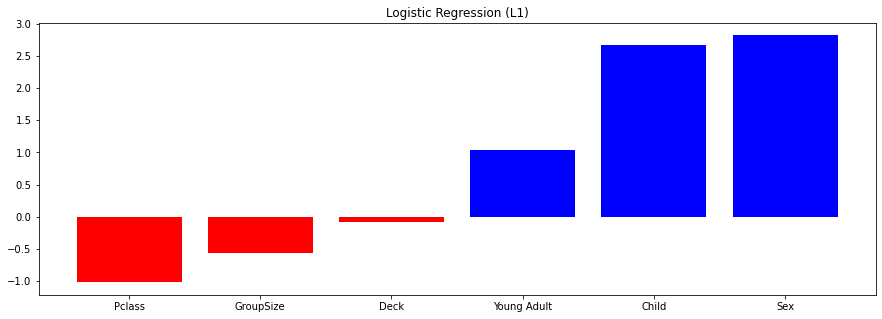

In [27]:
from sklearn.metrics import accuracy_score

print('logistic_regression (L1) accuracy:',accuracy_score(Y_train, LR_L1.predict(X_train)))
plot_coefficients(LR_L1, X_names, 'Logistic Regression (L1)', top_features = 3)

logistic_regression (L2) accuracy: 0.797979797979798


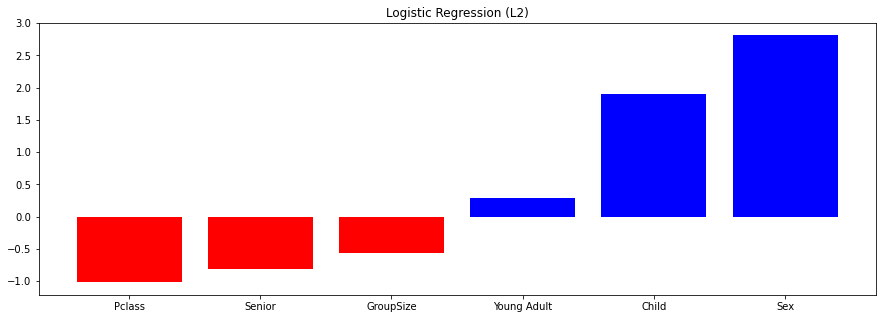

In [28]:
print('logistic_regression (L2) accuracy:',accuracy_score(Y_train, LR_L2.predict(X_train)))
plot_coefficients(LR_L2, X_names, 'Logistic Regression (L2)', top_features=3)

## Decision Tree and Random Forest

In [29]:
## Random Forest

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree 

#parameters = [{'kernel': ['linear'],
#                #'gamma': [1e-6, 1e-5, 1e-4],
#                'C': [0.1, 1, 10, 100, 1000]}]


#print("# Tuning hyper-parameters")
#clf = GridSearchCV(logreg, parameters, cv=10)
#clf.fit(X_train, Y_train)


#print('best parameters:')
#print(clf.best_params_)
#print('-------------------------------------')
#means = clf.cv_results_['mean_test_score']
#stds = clf.cv_results_['std_test_score']
#for mean, std, params in zip(means, stds, clf.cv_results_['params']):
#    print("%0.3f (+/-%0.03f) for %r"
#          % (mean, std * 2, params))

random_forest = RandomForestClassifier(criterion = 'entropy' , n_estimators=100)
random_forest.fit(X_train, Y_train)

CV_random_forest = cross_val_score( random_forest, X_train, Y_train, cv = 10, scoring='accuracy')
mean_random_forest = CV_random_forest.mean()
std_random_forest = CV_random_forest.std()
#Y_prediction = random_forest.predict(X_test)

random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
print(acc_random_forest)


RF = RandomForestClassifier(criterion='entropy',n_estimators=1000).fit(X_train, Y_train)

#print('Random Forest accuracy:',accuracy_score(Y_test, RF.predict(X_test)))


87.21


In [30]:
mean_random_forest

0.8238576779026217

In [31]:
Y_pred_RF = random_forest.predict(X_train)

# Saving other metric (Recall, Precision, F1-Score)

report = classification_report(Y_train, Y_pred_RF, output_dict=True)
recall_RF = report['0']['recall']
precision_RF = report['0']['precision']
f1_RF = report['0']['f1-score']

In [32]:
# Decision Tree

decision_tree = DecisionTreeClassifier(criterion = 'entropy' , max_depth=100) # Can change max depth
decision_tree.fit(X_train, Y_train)

CV_decision_tree = cross_val_score( decision_tree, X_train, Y_train, cv = 10, scoring='accuracy')
mean_decision_tree = CV_decision_tree.mean()
std_decision_tree = CV_decision_tree.std()
#Y_prediction = random_forest.predict(X_test)

decision_tree.score(X_train, Y_train)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
print(acc_decision_tree)

87.21


In [33]:
mean_decision_tree

0.8171285892634208

In [34]:
Y_pred_DT = decision_tree.predict(X_train)

# Saving other metric (Recall, Precision, F1-Score)

report = classification_report(Y_train, Y_pred_DT, output_dict=True)
recall_DT = report['0']['recall']
precision_DT = report['0']['precision']
f1_DT = report['0']['f1-score']

In [35]:
# for tree-based classifier's feature importance plotting
def plot_keyFeat_trees(classifier, feature_names, clf_id, top_features=5):
    importances = classifier.feature_importances_
    indices = np.argsort(importances)[::-1]
    indices_vis = indices[:top_features]
    
    plt.figure()
    plt.figure(figsize=(15, 5))
    plt.title(clf_id)
    plt.bar(range(top_features), importances[indices_vis],
       color="r", align="center")
    plt.xticks(range(top_features), indices)
    plt.xlim([-1, top_features])
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(0, top_features), feature_names[indices_vis], rotation=60, ha='right')
    plt.show()

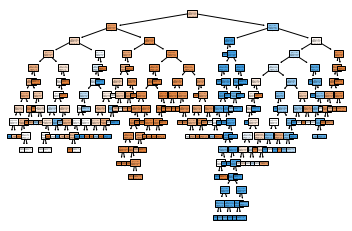

In [36]:
plot_tree(decision_tree.fit(X_train, Y_train), filled=True)
plt.show()

In [37]:
importances_RF = pd.DataFrame({'Feature':X_train.columns,'Importance':np.round(random_forest.feature_importances_,3)})
importances_RF = importances_RF.sort_values('Importance',ascending=False).set_index('Feature')
importances_RF.head(10)

,Importance
Feature,
Title,0.260
Sex,0.161
Pclass,0.145
Deck,0.140
GroupSize,0.113
Embarked,0.077
Adult,0.028
Child,0.027
Young Adult,0.026


C:\Users\Lenovo\anaconda3\envs\Titanic\lib\site-packages\pandas\plotting\_matplotlib\core.py:1373: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  return ax.bar(x, y, w, bottom=start, log=log, **kwds)


<AxesSubplot:xlabel='Feature'>

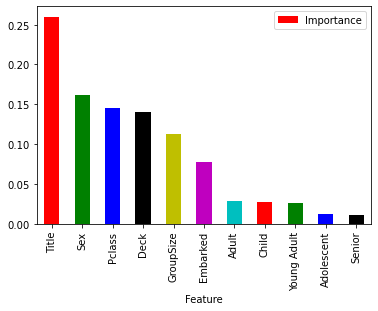

In [38]:

#Plot the data:
my_colours = list('rgbkymc')  #red, green, blue, black, etc.
importances_RF.plot.bar(color = 'rgbkymc')

In [39]:
importances_DT = pd.DataFrame({'Feature':X_train.columns,'Importance':np.round(decision_tree.feature_importances_,3)})
importances_DT = importances_DT.sort_values('Importance',ascending=False).set_index('Feature')
importances_DT.head(10)

,Importance
Feature,
Title,0.460
Pclass,0.184
Deck,0.104
GroupSize,0.103
Embarked,0.040
Adult,0.036
Young Adult,0.028
Child,0.019
Senior,0.015


C:\Users\Lenovo\anaconda3\envs\Titanic\lib\site-packages\pandas\plotting\_matplotlib\core.py:1373: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  return ax.bar(x, y, w, bottom=start, log=log, **kwds)


<AxesSubplot:xlabel='Feature'>

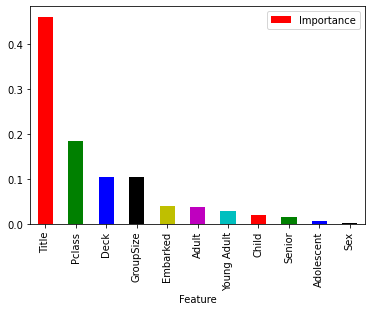

In [40]:
#Plot the data:
my_colours = list('rgbkymc')  #red, green, blue, black, etc.
importances_DT.plot.bar(color = 'rgbkymc')

## Support Vector Machine

In [41]:
from sklearn.svm import SVC

parameters = [{'kernel': ['linear', 'rbf'],
                'gamma': [1e-6, 1e-5, 1e-4],
                'C': [0.1, 1, 10, 100, 1000]}]


print("# Tuning hyper-parameters")
clf = GridSearchCV(SVC(), parameters, cv=10)
clf.fit(X_train, Y_train)


print('best parameters:')
print(clf.best_params_)
print('-------------------------------------')
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

# Tuning hyper-parameters
best parameters:
{'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
-------------------------------------
0.787 (+/-0.057) for {'C': 0.1, 'gamma': 1e-06, 'kernel': 'linear'}
0.616 (+/-0.007) for {'C': 0.1, 'gamma': 1e-06, 'kernel': 'rbf'}
0.787 (+/-0.057) for {'C': 0.1, 'gamma': 1e-05, 'kernel': 'linear'}
0.616 (+/-0.007) for {'C': 0.1, 'gamma': 1e-05, 'kernel': 'rbf'}
0.787 (+/-0.057) for {'C': 0.1, 'gamma': 0.0001, 'kernel': 'linear'}
0.616 (+/-0.007) for {'C': 0.1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.787 (+/-0.057) for {'C': 1, 'gamma': 1e-06, 'kernel': 'linear'}
0.616 (+/-0.007) for {'C': 1, 'gamma': 1e-06, 'kernel': 'rbf'}
0.787 (+/-0.057) for {'C': 1, 'gamma': 1e-05, 'kernel': 'linear'}
0.616 (+/-0.007) for {'C': 1, 'gamma': 1e-05, 'kernel': 'rbf'}
0.787 (+/-0.057) for {'C': 1, 'gamma': 0.0001, 'kernel': 'linear'}
0.616 (+/-0.007) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.787 (+/-0.057) for {'C': 10, 'gamma': 1e-06, 'kernel': 'linear'}
0.616 (+/-0.007) 

In [42]:
from sklearn.svm import SVC
# Can split up into Linear and Rbf. 

# Linear: ___________________________________

parameters = [{'kernel': ['linear'],
                'gamma': [1e-6, 1e-5, 1e-4],
                'C': [0.1, 1, 10, 100]}]

print("# Tuning hyper-parameters")
clf = GridSearchCV(SVC(), parameters, cv=10)
clf.fit(X_train, Y_train)

print('best parameters:')
print(clf.best_params_)
print('-------------------------------------')
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
linear = pd.DataFrame({'mean' : means , 'std' : stds , 'C' : clf.cv_results_['param_C'].data,
                       'gamma' : clf.cv_results_['param_gamma'].data, 'kernal' : clf.cv_results_['param_kernel'].data} )  

   
# Rbf: ____________________________________

parameters = [{'kernel': ['rbf'],
                'gamma': [1e-6, 1e-5, 1e-4],
                'C': [0.1, 1, 10, 100]}]

print("# Tuning hyper-parameters")
clf = GridSearchCV(SVC(), parameters, cv=10)
clf.fit(X_train, Y_train)

print('best parameters:')
print(clf.best_params_)
print('-------------------------------------')
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

rbf  =  pd.DataFrame({'mean' : means , 'std' : stds , 'C' : clf.cv_results_['param_C'].data,
                       'gamma' : clf.cv_results_['param_gamma'].data, 'kernal' : clf.cv_results_['param_kernel'].data} )  


# Tuning hyper-parameters
best parameters:
{'C': 0.1, 'gamma': 1e-06, 'kernel': 'linear'}
-------------------------------------
0.787 (+/-0.057) for {'C': 0.1, 'gamma': 1e-06, 'kernel': 'linear'}
0.787 (+/-0.057) for {'C': 0.1, 'gamma': 1e-05, 'kernel': 'linear'}
0.787 (+/-0.057) for {'C': 0.1, 'gamma': 0.0001, 'kernel': 'linear'}
0.787 (+/-0.057) for {'C': 1, 'gamma': 1e-06, 'kernel': 'linear'}
0.787 (+/-0.057) for {'C': 1, 'gamma': 1e-05, 'kernel': 'linear'}
0.787 (+/-0.057) for {'C': 1, 'gamma': 0.0001, 'kernel': 'linear'}
0.787 (+/-0.057) for {'C': 10, 'gamma': 1e-06, 'kernel': 'linear'}
0.787 (+/-0.057) for {'C': 10, 'gamma': 1e-05, 'kernel': 'linear'}
0.787 (+/-0.057) for {'C': 10, 'gamma': 0.0001, 'kernel': 'linear'}
0.787 (+/-0.057) for {'C': 100, 'gamma': 1e-06, 'kernel': 'linear'}
0.787 (+/-0.057) for {'C': 100, 'gamma': 1e-05, 'kernel': 'linear'}
0.787 (+/-0.057) for {'C': 100, 'gamma': 0.0001, 'kernel': 'linear'}
# Tuning hyper-parameters
best parameters:
{'C': 100, 'gamma'

In [43]:
clf.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_C', 'param_gamma', 'param_kernel', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'split5_test_score', 'split6_test_score', 'split7_test_score', 'split8_test_score', 'split9_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [44]:
linear['ParamCombo'] = linear[['C', 'gamma']].values.tolist()
rbf['ParamCombo'] = rbf[['C', 'gamma']].values.tolist()
linear

,mean,std,C,gamma,kernal,ParamCombo
0,0.786729,0.028599,0.1,1e-06,linear,"[0.1, 1e-06]"
1,0.786729,0.028599,0.1,1e-05,linear,"[0.1, 1e-05]"
2,0.786729,0.028599,0.1,0.0001,linear,"[0.1, 0.0001]"
3,0.786729,0.028599,1,1e-06,linear,"[1, 1e-06]"
4,0.786729,0.028599,1,1e-05,linear,"[1, 1e-05]"
5,0.786729,0.028599,1,0.0001,linear,"[1, 0.0001]"
6,0.786729,0.028599,10,1e-06,linear,"[10, 1e-06]"
7,0.786729,0.028599,10,1e-05,linear,"[10, 1e-05]"
8,0.786729,0.028599,10,0.0001,linear,"[10, 0.0001]"
9,0.786729,0.028599,100,1e-06,linear,"[100, 1e-06]"


In [45]:
linear['ParamCombo'] = linear['ParamCombo'].apply(str)

In [46]:
linear

,mean,std,C,gamma,kernal,ParamCombo
0,0.786729,0.028599,0.1,1e-06,linear,"[0.1, 1e-06]"
1,0.786729,0.028599,0.1,1e-05,linear,"[0.1, 1e-05]"
2,0.786729,0.028599,0.1,0.0001,linear,"[0.1, 0.0001]"
3,0.786729,0.028599,1,1e-06,linear,"[1, 1e-06]"
4,0.786729,0.028599,1,1e-05,linear,"[1, 1e-05]"
5,0.786729,0.028599,1,0.0001,linear,"[1, 0.0001]"
6,0.786729,0.028599,10,1e-06,linear,"[10, 1e-06]"
7,0.786729,0.028599,10,1e-05,linear,"[10, 1e-05]"
8,0.786729,0.028599,10,0.0001,linear,"[10, 0.0001]"
9,0.786729,0.028599,100,1e-06,linear,"[100, 1e-06]"


In [47]:
# Extract scores from best models

SVM_L = SVC(C=0.1, kernel='linear', gamma = 1e-06).fit(X_train, Y_train)
SVM_rbf = SVC(C=100, kernel='rbf', gamma = 0.0001).fit(X_train, Y_train)

# Extract scores:
CV_SVM_L = cross_val_score( SVM_L , X_train, Y_train, cv = 10, scoring='accuracy')
mean_SVM_L = CV_SVM_L.mean()
std_SVM_L = CV_SVM_L.std()

CV_SVM_rbf = cross_val_score( SVM_rbf, X_train, Y_train, cv = 10, scoring='accuracy')
mean_SVM_rbf = CV_SVM_rbf.mean()
std_SVM_rbf = CV_SVM_rbf.std()


In [48]:
std_SVM_L

0.028599350013463757

In [49]:
## Linear Kernal

Y_pred_SVM_L = SVM_L.predict(X_train)

# Saving other metric (Recall, Precision, F1-Score)

report = classification_report(Y_train, Y_pred_SVM_L, output_dict=True)
recall_SVM_L = report['0']['recall']
precision_SVM_L = report['0']['precision']
f1_SVM_L = report['0']['f1-score']


## RBF Kernal

Y_pred_SVM_rbf = SVM_rbf.predict(X_train)

# Saving other metric (Recall, Precision, F1-Score)

report = classification_report(Y_train, Y_pred_SVM_rbf, output_dict=True)
recall_SVM_rbf = report['0']['recall']
precision_SVM_rbf = report['0']['precision']
f1_SVM_rbf = report['0']['f1-score']

## Naive Bayes (Gaussian Assumption)

In [50]:
from sklearn.naive_bayes import GaussianNB

gaussian = GaussianNB() 
gaussian.fit(X_train, Y_train)  
#Y_pred = gaussian.predict(X_test)  
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)

parameters = [{#'kernel': ['linear', 'rbf'],
                'gamma': [1e-6, 1e-5, 1e-4],
                'C': [0.1, 1, 10, 100, 1000]}]


#print("# Tuning hyper-parameters")
#clf = GridSearchCV(gaussian, parameters, cv=10)
#clf.fit(X_train, Y_train)

CV_GNB = cross_val_score(gaussian, X_train, Y_train, cv=10, n_jobs=1, scoring = 'accuracy')
mean_GNB = CV_GNB.mean()
std_GNB = CV_GNB.std()


# We can work out mean and std as for nearest neighbours. No hyperparameters to tune ( oh yes there are what about mu and sigma?)

#print('best parameters:')
#print(clf.best_params_)
#print('-------------------------------------')
#means = clf.cv_results_['mean_test_score']
#stds = clf.cv_results_['std_test_score']
#for mean, std, params in zip(means, stds, clf.cv_results_['params']):
#    print("%0.3f (+/-%0.03f) for %r"
#          % (mean, std * 2, params))

In [51]:
std_GNB

0.029032861387690644

In [52]:
mean_GNB

0.7699126092384518

In [53]:
Y_pred_NB = gaussian.predict(X_train)

# Saving other metric (Recall, Precision, F1-Score)

report = classification_report(Y_train, Y_pred_NB, output_dict=True)
recall_NB = report['0']['recall']
precision_NB = report['0']['precision']
f1_NB = report['0']['f1-score']

In [54]:
gaussian.get_params().keys()

dict_keys(['priors', 'var_smoothing'])

In [55]:
gaussian.fit(X_train, Y_train)

GaussianNB()

## Perceptron 

In [56]:
from sklearn.linear_model import Perceptron

perceptron = Perceptron(max_iter=100)
perceptron.fit(X_train, Y_train)

CV_perceptron = cross_val_score(perceptron, X_train, Y_train, cv=10, scoring = 'accuracy')
mean_perceptron = CV_perceptron.mean()
std_perceptron = CV_perceptron.std()

In [57]:
std_perceptron

0.12548549268237857

In [58]:
Y_pred_perceptron = perceptron.predict(X_train)

# Saving other metric (Recall, Precision, F1-Score)

report = classification_report(Y_train, Y_pred_perceptron, output_dict=True)
recall_perceptron = report['0']['recall']
precision_perceptron = report['0']['precision']
f1_perceptron = report['0']['f1-score']

## Deep Learning (Multi Layer Perceptron)

In [59]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.utils import np_utils

Using TensorFlow backend.


batch_size = 128
nb_classes = 10
im_dim = 784 # the total pixel number 
nb_hidden = 256
nb_epoch = 5

(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(60000, im_dim)
X_test = X_test.reshape(10000, im_dim)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

In [60]:
nb_hidden = len(X_names)
nb_epoch = 5 
nb_classes = 2

# Keras requires y-data in (N, # classes) shape, not (N). For multiclass we can use OneHotEncoder. 
Y_train_deep = np_utils.to_categorical(Y_train, nb_classes) 
Y_test_deep = np_utils.to_categorical(Y_test, nb_classes)

In [61]:
# Deep Multilayer Perceptron model
model = Sequential()
model.add(Dense(input_dim=nb_hidden,units=nb_hidden))
model.add(Activation('relu')) 
model.add(Dropout(0.2))
model.add(Dense(input_dim=nb_hidden,units=nb_hidden))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(input_dim=nb_hidden, units=(nb_classes)))
model.add(Activation('sigmoid')) # converts to a categorical prediction at the end

# use sparse_categorical_crossentropy is we havent one hot encoded the output labels. 
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 11)                132       
_________________________________________________________________
activation_1 (Activation)    (None, 11)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 11)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 11)                132       
_________________________________________________________________
activation_2 (Activation)    (None, 11)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 11)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                

In [62]:
# Train
history = model.fit(X_train, Y_train_deep, epochs=nb_epoch , 
                   validation_split = 0.2 )#,
                   # batch_size=batch_size, verbose=1)


Train on 712 samples, validate on 179 samples
Epoch 1/5
712/712 [==============================] - 0s 234us/step - loss: 0.7348 - accuracy: 0.4916 - val_loss: 0.7060 - val_accuracy: 0.3799
Epoch 2/5
712/712 [==============================] - 0s 22us/step - loss: 0.7076 - accuracy: 0.5239 - val_loss: 0.6727 - val_accuracy: 0.6425
Epoch 3/5
712/712 [==============================] - 0s 31us/step - loss: 0.6867 - accuracy: 0.5604 - val_loss: 0.6587 - val_accuracy: 0.6816
Epoch 4/5
712/712 [==============================] - 0s 44us/step - loss: 0.6731 - accuracy: 0.6011 - val_loss: 0.6395 - val_accuracy: 0.6872
Epoch 5/5
712/712 [==============================] - 0s 22us/step - loss: 0.6575 - accuracy: 0.6320 - val_loss: 0.6196 - val_accuracy: 0.7151


In [63]:
# Evaluate
#evaluation = model.evaluate(X_test, Y_test_deep, verbose=1)
#print('Summary: Loss over the test dataset: %.2f, Accuracy: %.2f' % (evaluation[0], evaluation[1]))

In [64]:
## Deep learning only really outperforms other methods as data increases into a big data scenario. 

## Summary 

results = pd.DataFrame({
    'Model': ['KNN', 
              'Logistic Regression (Ridge)', 'LASSO-Logisitc',  
              'Random Forest', 'Decision Tree' , 
              'SVM - Linear Kernel', 'SVM - rbf Kernel', 
              'Naive Bayes' , 
              'Perceptron'],
    'Mean Accuracy': [mean_neigh, 
                      mean_ridge, mean_lasso, 
                      mean_random_forest, mean_decision_tree, 
                      mean_SVM_L , mean_SVM_rbf,  
                      mean_GNB, 
                      mean_perceptron ],
    'Accuracy Error' : [std_neigh, 
                      std_ridge, std_lasso, 
                      std_random_forest, std_decision_tree,
                      std_SVM_L, std_SVM_rbf, 
                      std_GNB, 
                      std_perceptron ]
        })


#result_df_one_hot_nofare = results.sort_values(by='Mean Accuracy', ascending=False)
#result_df_one_hot_nofare.to_pickle('result_df_one_hot_nofare.pkl')

In [65]:
results = pd.DataFrame({
    'Model': ['KNN', 
              'Logistic Regression (Ridge)', 'LASSO-Logisitc',  
              'Random Forest', 'Decision Tree' , 
              'SVM - Linear Kernel', 'SVM - rbf Kernel', 
              'Naive Bayes' , 
              'Perceptron'],
    'Mean Accuracy': [mean_neigh, 
                      mean_ridge, mean_lasso, 
                      mean_random_forest, mean_decision_tree, 
                      mean_SVM_L , mean_SVM_rbf,  
                      mean_GNB, 
                      mean_perceptron ],
    'Accuracy Error' : [std_neigh, 
                      std_ridge, std_lasso, 
                      std_random_forest, std_decision_tree,
                      std_SVM_L, std_SVM_rbf, 
                      std_GNB, 
                      std_perceptron ],
    'Recall' : [recall_knn, 
                recall_L2, recall_L1 , 
                recall_RF , recall_DT , 
                recall_SVM_L , recall_SVM_rbf , 
                recall_NB , recall_perceptron ] ,
    'Precision' : [precision_knn, 
                precision_L2, precision_L1 , 
                precision_RF , precision_DT , 
                precision_SVM_L , precision_SVM_rbf , 
                precision_NB , precision_perceptron ] ,
    'F1-Score' : [f1_knn, 
                f1_L2, f1_L1 , 
                f1_RF , f1_DT , 
                f1_SVM_L , f1_SVM_rbf , 
                f1_NB , f1_perceptron ]
    })


result_df_train_final = results.sort_values(by='Mean Accuracy', ascending=False)
result_df_train_final.to_pickle('result_df_train_final.pkl')

In [66]:
## Highlghting the best features within dataframe:

result_df_train_final

#result_df_train_final.style.apply(lambda x: ["background: yellow" if v > x.iloc[0] else "" for v in x], axis = 1)

result_df_train_final.style\
    .highlight_max(color = 'yellow', axis = 0, subset=['Mean Accuracy','Recall','Precision','F1-Score'])\
    .highlight_min(color = 'yellow', axis = 0, subset=['Accuracy Error'])\
    .set_precision(3)


#df.style\
#  .applymap(color_negative_red)\
#  .apply(highlight_max)\
#  .set_precision(2)


,Model,Mean Accuracy,Accuracy Error,Recall,Precision,F1-Score
0,KNN,0.842,0.041,0.923,0.856,0.889
3,Random Forest,0.824,0.047,0.944,0.862,0.901
4,Decision Tree,0.817,0.051,0.956,0.854,0.902
6,SVM - rbf Kernel,0.788,0.028,0.852,0.812,0.832
1,Logistic Regression (Ridge),0.788,0.026,0.872,0.813,0.842
2,LASSO-Logisitc,0.788,0.026,0.872,0.813,0.842
5,SVM - Linear Kernel,0.787,0.029,0.852,0.811,0.831
7,Naive Bayes,0.770,0.029,0.752,0.857,0.801
8,Perceptron,0.704,0.125,0.689,0.887,0.775


### Proviously ran and analysed in iterative steps. 
Must change the dataset in code block 6 to replicate.

In [67]:
#result_df_train_nofare

In [68]:
#result_df_UpLow_nofare

In [69]:
#result_df_one_hot_nofare

In [70]:
#result_df_one_hot_nofare.names()

In [71]:
#result_df_one_hot

In [72]:
#result_df_train

### Feature Selection Process:

We can try to tabulate all results from the pickles stored: However it seems that the one-hot-encoded age categories with no fare variable produced the best results. K-NN and decision tree/random forest produced the best results. We can plot the results for the dataset **train_one_hot_nofare**.  

Text(0.5, 0.98, 'Comparison of Machine Leanring Algorithms')

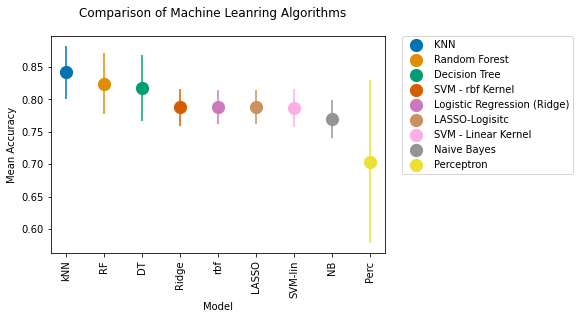

In [73]:
%matplotlib inline

results = pd.read_pickle('result_df_train_final.pkl') 

x = [0,1,2,3,4,5,6,7,8]
labels = ['kNN', 'RF', 'DT', 'Ridge', 'rbf', 'LASSO', 'SVM-lin', 'NB', 'Perc']

colour = sns.color_palette("colorblind")
ax = sns.pointplot(x = 'Model', y = 'Mean Accuracy',
                    data=results, join=False, hue = 'Model', scale =1.5 ,
                     palette = colour )
plt.xticks(x, labels,rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

ax.errorbar(x = results['Model'], y = results['Mean Accuracy'], yerr=results['Accuracy Error'], 
            fmt = ' ' , ecolor = colour)
plt.suptitle('Comparison of Machine Leanring Algorithms')

###  We can explore AUC and ROC curves of the chose model evaluated on the test set. 

In [74]:
### Our Test Set
test_one_hot_nofare

# Data Set-Up
X_test = test_one_hot_nofare.drop('Survived' , axis = 1)
Y_test = test_one_hot_nofare['Survived']

# Refresh Memory
X_train = train_one_hot_nofare.drop('Survived', axis = 1)
Y_train = train_one_hot_nofare['Survived']

### Final Model is a kNN-Classifier. 

No Skill: ROC AUC=0.500
kNN K=5: ROC AUC=0.808


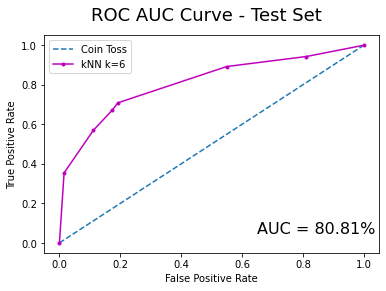

In [75]:
# Choose a best model and use this to explore ROC and AUC on the test set. 

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(Y_test))]

# fit a model
final_model = KNeighborsClassifier(n_neighbors=6)
final_model.fit(X_train, Y_train)
# predict probabilities
lr_probs = final_model.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(Y_test, ns_probs)
lr_auc = roc_auc_score(Y_test, lr_probs)
lr_auc_per= lr_auc*100
# print scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('kNN K=5: ROC AUC=%.3f' % (lr_auc))


# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(Y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(Y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='Coin Toss')
pyplot.plot(lr_fpr, lr_tpr, marker='.', color='m' , label='kNN k=6')
# fix axis, title and legends 
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
plt.suptitle('ROC AUC Curve - Test Set', fontsize=18)
plt.text(0.65,0.05, 'AUC = {}%'.format("%.2f" % lr_auc_per), color='Black', fontsize=16 )


# show the plot
pyplot.show()

              precision    recall  f1-score   support

           0       0.86      0.92      0.89       549
           1       0.86      0.75      0.80       342

    accuracy                           0.86       891
   macro avg       0.86      0.84      0.85       891
weighted avg       0.86      0.86      0.86       891



Text(0.5, 0.98, 'Confusion Matrix - Test Set    ')

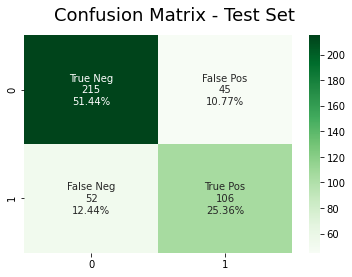

In [76]:
from sklearn.metrics import classification_report, confusion_matrix

Y_pred_test = final_model.predict(X_test)

cf_matrix = confusion_matrix(Y_test, Y_pred_test)

#print(confusion_matrix(Y_train, Y_pred))
print(classification_report(Y_train, Y_pred))

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Greens')
plt.suptitle('Confusion Matrix - Test Set    ', fontsize=18)

In [77]:
print(classification_report(Y_test, Y_pred_test))

report = classification_report(Y_test, Y_pred_test, output_dict=True)

pd.DataFrame(report)

              precision    recall  f1-score   support

           0       0.81      0.83      0.82       260
           1       0.70      0.67      0.69       158

    accuracy                           0.77       418
   macro avg       0.75      0.75      0.75       418
weighted avg       0.77      0.77      0.77       418



,0,1,accuracy,macro avg,weighted avg
precision,0.805243,0.701987,0.767943,0.753615,0.766213
recall,0.826923,0.670886,0.767943,0.748905,0.767943
f1-score,0.815939,0.686084,0.767943,0.751012,0.766855
support,260.000000,158.000000,0.767943,418.000000,418.000000


### Lets see how the ROC curve for Random Forest looks. 

No Skill: ROC AUC=0.500
kNN K=5: ROC AUC=0.807


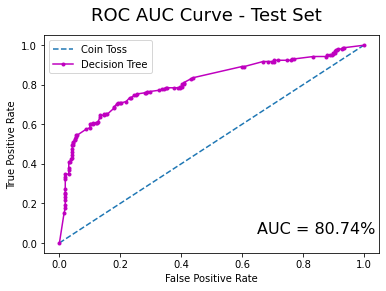

In [78]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot


# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(Y_test))]

# fit a model
final_model2 = RandomForestClassifier(criterion = 'entropy' , n_estimators=100)
final_model2.fit(X_train, Y_train)
# predict probabilities
lr_probs = final_model2.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(Y_test, ns_probs)
ns_auc_per = ns_auc*100
lr_auc = roc_auc_score(Y_test, lr_probs)
lr_auc_per = lr_auc*100
# print scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('kNN K=5: ROC AUC=%.3f' % (lr_auc))


# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(Y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(Y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='Coin Toss')
pyplot.plot(lr_fpr, lr_tpr, marker='.', color='m' , label='Decision Tree')
# fix axis, title and legends 
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
plt.suptitle('ROC AUC Curve - Test Set', fontsize=18)
plt.text(0.65,0.05, 'AUC = {}%'.format("%.2f" % lr_auc_per), color='Black', fontsize=16 )

#"Shepherd {} is on duty.".format(shepherd)
# show the plot
pyplot.show()

              precision    recall  f1-score   support

           0       0.86      0.92      0.89       549
           1       0.86      0.75      0.80       342

    accuracy                           0.86       891
   macro avg       0.86      0.84      0.85       891
weighted avg       0.86      0.86      0.86       891



Text(0.5, 0.98, 'Confusion Matrix - Test Set    ')

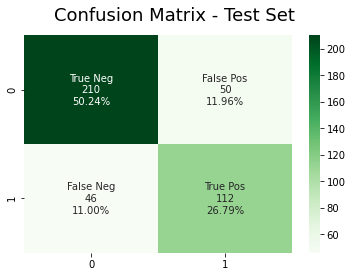

In [79]:
from sklearn.metrics import classification_report, confusion_matrix

Y_pred_test = final_model2.predict(X_test)

cf_matrix = confusion_matrix(Y_test, Y_pred_test)

#print(confusion_matrix(Y_train, Y_pred))
print(classification_report(Y_train, Y_pred))

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Greens')
plt.suptitle('Confusion Matrix - Test Set    ', fontsize=18)

In [80]:
importances_DT = pd.DataFrame({'Feature':X_train.columns,'Importance':np.round(final_model2.feature_importances_,3)})
importances_DT = importances_DT.sort_values('Importance',ascending=False).set_index('Feature')
importances_DT.head(10)

,Importance
Feature,
Title,0.244
Sex,0.180
Pclass,0.153
Deck,0.139
GroupSize,0.118
Embarked,0.077
Child,0.023
Young Adult,0.023
Adult,0.022


C:\Users\Lenovo\anaconda3\envs\Titanic\lib\site-packages\pandas\plotting\_matplotlib\core.py:1373: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  return ax.bar(x, y, w, bottom=start, log=log, **kwds)


<AxesSubplot:xlabel='Feature'>

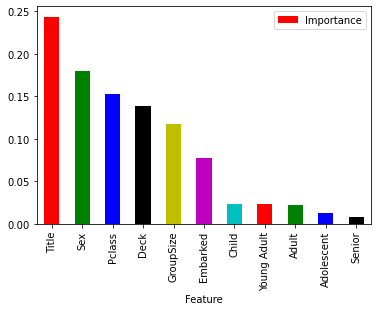

In [81]:
#Plot the data:
my_colours = list('rgbkymc')  #red, green, blue, black, etc.
importances_DT.plot.bar(color = 'rgbkymc')

### End of Notebook. 

Thank you. 